In [1]:
%cd /raid6/home/yokoyama/har-for-or/
import os
import sys
from glob import glob
import pickle

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score

sys.path.append(".")
from src.model import SQVAE
from src.utils import video, yaml_handler, vis

/raid6/home/yokoyama/har-for-or


/raid6/home/yokoyama/har-for-or/.venv/lib/python3.10/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


In [2]:
# dataset_num = 5
# video_num = 11

# # load preds
# data_root = f"../datasets/dataset{dataset_num:02d}/train/{video_num:02d}"
# paths = glob(os.path.join(data_root, f"pred_{model_type}", "*"))
# results = []
# for path in paths:
#     with open(path, "rb") as f:
#         results.append(pickle.load(f))

# # count labels
# labels = {}
# for result in results:
#     key = result["key"]
#     video_num, n_frame, _id = key.split("_")
#     key = f"{video_num}_{_id}"

#     if key not in labels:
#         labels[key] = []
#     labels[key].append(result["label"])

# # get most frequent labels
# data = []
# for key, val in labels.items():
#     unique, counts = np.unique(val, return_counts=True)
#     maxidx = np.argmax(counts)
#     label = unique[maxidx].item()
#     data.append([key, label])

# # save
# path = f"../datasets/dataset{dataset_num:02d}/annotation/role_train_{video_num}.txt"
# np.savetxt(path, data, fmt="%s", delimiter=" ")

# 精度評価

In [3]:
# test
model_type = "sqvae"
dataset_num = 5
if dataset_num == 3:
    v = 0
elif dataset_num == 4:
    v = 1
elif dataset_num == 5:
    v = 2
checkpoint_dir = f"models/individual/{model_type}/version_{v}"


# load classes
path = f"../datasets/dataset{dataset_num:02d}/annotation/classes.txt"
classes = np.loadtxt(path, str, usecols=0, delimiter=",")
classes = [c.title() for c in classes]

# load annotation
path = glob(f"../datasets/dataset{dataset_num:02d}/annotation/*test*.txt")[0]
video_num = int(os.path.basename(path).split(".")[0].split("_")[2])
annotations = np.loadtxt(path, str, skiprows=1, delimiter=" ")

# load config
config = yaml_handler.load(f"{checkpoint_dir}/individual-{model_type}.yaml")
seq_len = config.seq_len
stride = config.stride
if config.mask_leg:
    n_pts = 13 + 2
else:
    n_pts = 17 + 2

# load preds
data_root = f"../datasets/dataset{dataset_num:02d}/test/{video_num:02d}"
paths = glob(os.path.join(data_root, f"pred_{model_type}", "*"))
results = []
for path in paths:
    with open(path, "rb") as f:
        results.append(pickle.load(f))

In [4]:
label_preds = []
label_gts = []
miss_ids = []
ann_keys = annotations.T[0]
for result in results:
    key = result["key"]
    video_num, n_frame, label = key.split("_")
    n_frame = int(n_frame)
    key = f"{video_num}_{label}"
    label_pred = result["label"]
    label_preds.append(label_pred)

    ann_tmp = annotations[ann_keys == key]
    if len(ann_tmp) >= 2:
        # groud truth is chenged sometimes since the tracking model mistakes
        ann_n_frames = ann_tmp.T[2].astype(int)
        ann_tmp = ann_tmp[ann_n_frames <= n_frame][-1]
        label_gt = int(ann_tmp[1])
    else:
        label_gt = int(ann_tmp[0, 1])
    label_gts.append(label_gt)

    if label_pred != label_gt and int(label) not in miss_ids:
        miss_ids.append(int(label))

miss_ids = np.array(miss_ids)

0.9453572793274742


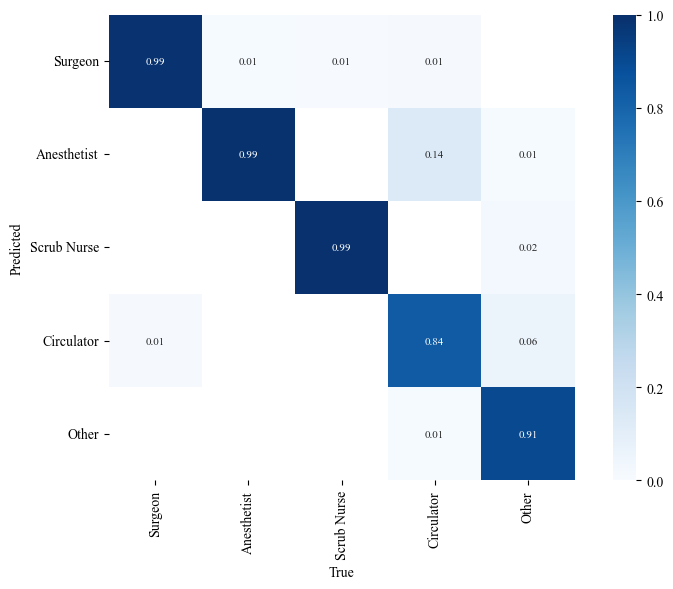

In [5]:
img_dir = f"../datasets/dataset{dataset_num:02d}/images"
os.makedirs(img_dir, exist_ok=True)

print(accuracy_score(label_gts, label_preds))
cm = confusion_matrix(label_gts, label_preds).T
figpath = f"{img_dir}/cm_test_{video_num}.png"
vis.plot_cm(cm, classes, figpath, normalize=True)

# 詳細な分析

In [6]:
data_dirs = glob(f"../datasets/dataset{dataset_num:02d}/train/*/") + glob(
    f"../datasets/dataset{dataset_num:02d}/test/*/"
)

# sort by video_num
data_dirs = sorted(data_dirs, key=lambda x: int(os.path.basename(os.path.dirname(x))))

In [7]:
# create image dirs
mse_kps_dir = f"{img_dir}/mse_kps"
os.makedirs(mse_kps_dir, exist_ok=True)
mse_bbox_dir = f"{img_dir}/mse_bbox"
os.makedirs(mse_bbox_dir, exist_ok=True)
mse_cls_dir = f"{img_dir}/clustering"
os.makedirs(mse_cls_dir, exist_ok=True)


for data_dir in tqdm(data_dirs):
    video_num = os.path.basename(os.path.dirname(data_dir))

    # load preds
    paths = glob(os.path.join(data_dir, f"pred_{model_type}", "*"))
    results = []
    for path in paths:
        with open(path, "rb") as f:
            results.append(pickle.load(f))

    # collect preds
    mse_kps_dict = {}
    mse_bbox_dict = {}
    label_counts = {i: {} for i in range(config.n_clusters)}
    max_n_frame = 0
    for result in results:
        key = result["key"]
        n_frame = int(key.split("_")[1])
        if max_n_frame < n_frame:
            max_n_frame = n_frame
        label = result["id"]

        # collect mse
        if label not in mse_kps_dict:
            mse_kps_dict[label] = {}
            mse_bbox_dict[label] = {}
        mse_kps_dict[label][n_frame] = result["mse_kps"]
        mse_bbox_dict[label][n_frame] = result["mse_bbox"]

        # label count
        label_pred = int(result["label"])
        if n_frame not in label_counts[label_pred]:
            label_counts[label_pred][n_frame] = 0
        label_counts[label_pred][n_frame] += 1

    mse_kps_figpath = f"{mse_kps_dir}/mse_kps_{video_num}.png"
    vis.plot_mse(
        mse_kps_dict,
        max_n_frame,
        stride,
        0.015,
        "MSE of Keypoints",
        10,
        mse_kps_figpath,
        False,
        ylim=(0, 0.1),
    )

    mse_bbox_figpath = f"{mse_bbox_dir}/mse_bbox_{video_num}.png"
    vis.plot_mse(
        mse_bbox_dict,
        max_n_frame,
        stride,
        0.01,
        "MSE of Bbox",
        10,
        mse_bbox_figpath,
        False,
        ylim=(0, 0.02),
    )

    mse_cls_figpath = f"{mse_cls_dir}/label_ratio_cumsum_{video_num}.png"
    vis.plot_label_ratio_cumsum(label_counts, classes, max_n_frame, stride, 30, mse_cls_figpath, False)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


In [8]:
# print("clustering label")
# X = np.array(latent_features["ze"]).reshape(-1, config.latent_ndim * n_pts * 2)
# labels = np.array(latent_features["label"])
# vis.plot_tsne(X, labels, 10, None, True, cmap="tab10")

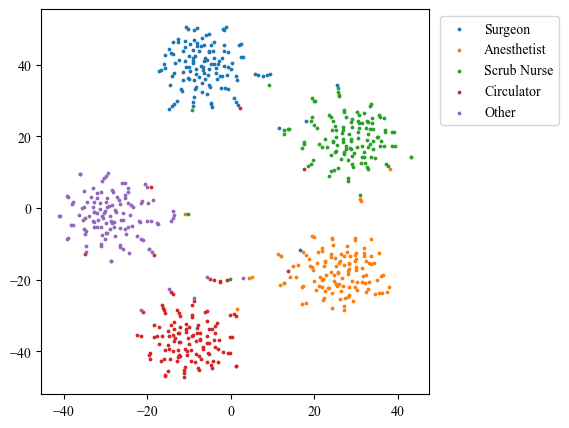

In [9]:
# tsne of codebooks
model = SQVAE(config)
model.configure_model()
checkpoint_path = sorted(glob(f"{checkpoint_dir}/*.ckpt"))[-1]
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint["state_dict"])
books = {i: book.detach().numpy() for i, book in enumerate(model.quantizer.books)}
X = np.array([book for book in books.values()]).reshape(-1, config.latent_ndim)
labels = np.array(
    [[c for _ in range(config.book_size)] for c in range(config.n_clusters)]
).ravel()
path = f"{img_dir}/t-sen_codebooks.jpg"
vis.plot_tsne(X, labels, classes, 10, path, True, cmap="tab10")